# Intercomparison Campaigns

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the access and usability of data from intercomparison campaigns. Example usage of the Climate Data Store (CDS) Frontend for Radiosonde data.

    Author: M. Blaschek
    Date: 09.2020
    Contact: michael.blaschek [at] univie.ac.at
    License: C3S, 2020


In [1]:
# %pylab inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) # just cosmetics

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')

## Request soundings from an intercomparison campaign

1. Need to request with IDs
2. Import data
3. Plot

In [3]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'statid': ['0-20100-0-01802','0-20100-0-01803', '0-20100-0-01804', '0-20100-0-01805'],
                   'format': 'csv'                   
               })

if True:
    # Start Download
    r.download(target='download.zip')
    # Check file size
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    # Unzip the Data Stream
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/1")
    print(z.namelist())
    z.extractall(path='./example_data/1')
    z.close()
    os.remove('download.zip')
    print("Time elapsed: ", time.time()-t0, "s")

2020-09-10 14:45:12,433 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-09-10 14:45:12,611 INFO Request is completed
2020-09-10 14:45:12,614 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1599737705.7595785-26515-8-f6594316-6cca-4cae-8ad6-d07f8a7117af.zip to download.zip (270.6K)
2020-09-10 14:45:13,269 INFO Download rate 414.3K/s


Unzipping retrieved files: to ./exampla_data/1
['temperature.csv']
Time elapsed:  0.9181435108184814 s


---
### Read data:

In [4]:
import pandas as pd
pd.set_option('display.width',None)
data = pd.read_csv('example_data/1/temperature.csv', index_col=0)

---
### Select data from one ascent: experiment 002

In [5]:
ascent = '-002'
#
# extract following data from each sensor of ascent #002:
# temperature, pressure and datetime
#
temperature = []
pressure = []
datetime = []
for i in data.statid.drop_duplicates():
    print('statid: ' + i)
    buffer = data[data.trajectory_label == i + ascent]
    print('trajectory_label: ' + i + ascent)
    temperature.append(np.array(buffer.ta))
    pressure.append(np.array(buffer.plev))
    datetime.append(np.array(buffer.time))
#    
# get the time into the right shape for later plotting:
# minutes after the ascent start
#
for j in range(len(datetime)):
    for i in range(len(datetime[j])):
        if(i == 0):
            datezero = pd.to_datetime(datetime[j][0])
        datetime[j][i] = (datezero - pd.to_datetime(datetime[j][i]))/np.timedelta64(1,'m')  # convert to minutes

statid: 0-20100-0-01802
trajectory_label: 0-20100-0-01802-002
statid: 0-20100-0-01803
trajectory_label: 0-20100-0-01803-002
statid: 0-20100-0-01804
trajectory_label: 0-20100-0-01804-002
statid: 0-20100-0-01805
trajectory_label: 0-20100-0-01805-002


---
### Plot the prepared data:

In [6]:
# plot settings:
#
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

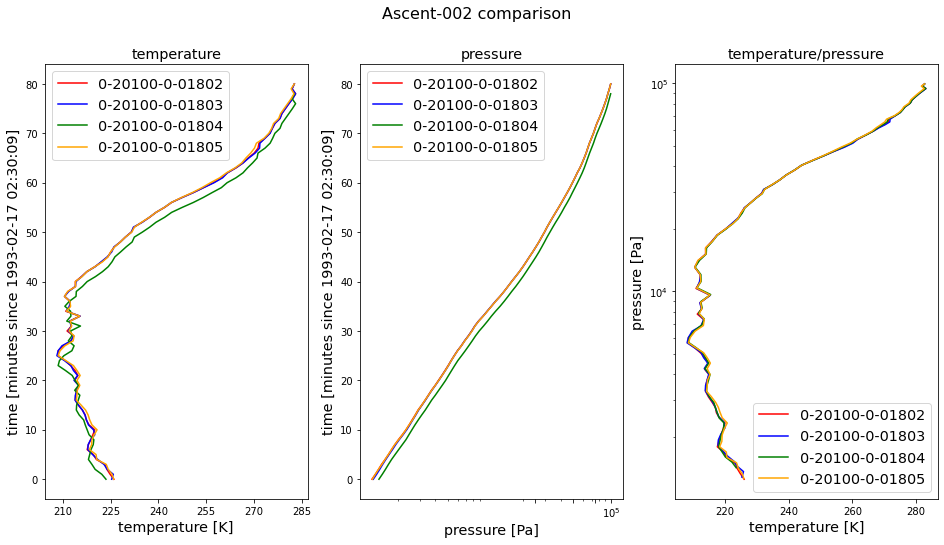

In [7]:
import matplotlib
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#
# Plotting temperature over time:
#
ax1.plot(temperature[0], datetime[0], c='red')
ax1.plot(temperature[1], datetime[1], c='blue')
ax1.plot(temperature[2], datetime[2], c='green')
ax1.plot(temperature[3], datetime[3], c='orange')
ax1.set(xlabel='temperature [K]', ylabel ='time [minutes since ' + np.min(buffer.time) + ']', title='temperature')
ax1.legend(data.statid.drop_duplicates(), loc='best')
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
#
# Plotting pressure over time:
#
ax2.semilogx(pressure[0], datetime[0], c='red')
ax2.semilogx(pressure[1], datetime[1], c='blue')
ax2.semilogx(pressure[2], datetime[2], c='green')
ax2.semilogx(pressure[3], datetime[3], c='orange')
ax2.set(xlabel='pressure [Pa]', ylabel ='time [minutes since ' + np.min(buffer.time) + ']', title='pressure')
ax2.legend(data.statid.drop_duplicates(), loc='best')
ax2.xaxis.set_major_locator(plt.MaxNLocator(6))
#
# Plotting pressure over temperature:
#
ax3.semilogy(temperature[0], (pressure[0]), c='red')
ax3.semilogy(temperature[1], (pressure[1]), c='blue')
ax3.semilogy(temperature[2], (pressure[2]), c='green')
ax3.semilogy(temperature[3], (pressure[3]), c='orange')
ax3.set(xlabel ='temperature [K]', ylabel='pressure [Pa]', title='temperature/pressure')
ax3.legend(data.statid.drop_duplicates(), loc='best')
#     -
fig.suptitle('Ascent'+ascent+' comparison', fontsize=16)
plt.show()
plt.close(fig)

---
## Plot the pressure differences to the first sonde

In [8]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

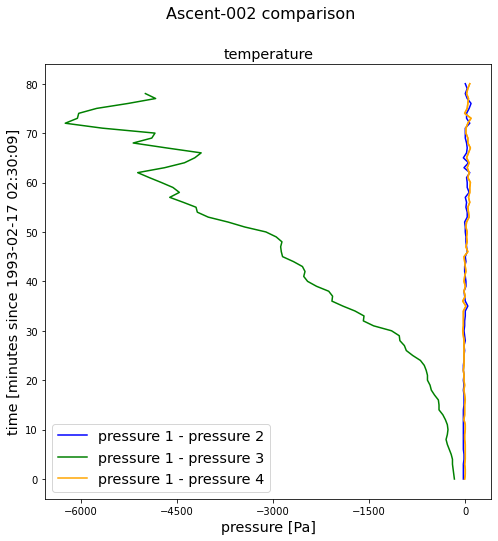

<Figure size 576x576 with 0 Axes>

In [9]:
fig, (ax1) = plt.subplots(1)
#
# Plotting pressur differences over time:
# pressure[0] is the longest data, so it will be shortened to the length of the comparison counterpart
#
ax1.plot(pressure[0][:len(pressure[1])] - pressure[1], datetime[1][:len(pressure[1])], c='blue')
ax1.plot(pressure[0][:len(pressure[2])] - pressure[2], datetime[2][:len(pressure[2])], c='green')
ax1.plot(pressure[0][:len(pressure[3])] - pressure[3], datetime[3][:len(pressure[3])], c='orange')
ax1.plot(pressure[0] - pressure[3], datetime[0], c='orange')
ax1.set(xlabel='pressure [Pa]', ylabel ='time [minutes since ' + np.min(buffer.time) + ']', title='temperature')
ax1.legend(['pressure 1 - pressure 2', 'pressure 1 - pressure 3', 'pressure 1 - pressure 4'], loc='best')
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
#
fig.suptitle('Ascent'+ascent+' comparison', fontsize=16)
plt.figure(figsize=(8, 8))
plt.show()
plt.close(fig)

## Interpolating pressure data for sonde comparison:

### Interpolate the sonde pressure from one reference sonde to all the other sonds:

There is no height information, so the interpolation hast do be done over the time data.

This is a viable solution since all sensors were mounted on the same weather balloon and were at the exact same height all the time.

In [10]:
import os
from scipy.interpolate import interp1d
import sys

In [11]:
# Easy interpolation with SciPy:
# forward interpolation pressure on time:
#
f = interp1d( np.log(np.array(pressure[0])), np.array(datetime[0]))

#
# for any number of pressure levels:
#
pressure_list = [75000., 50000., 25000.] # Pa
pres_delta = []
for j in range(len(pressure_list)):
    print('Time at '+str(pressure_list[j])+' Pa: ' + str(f(np.log(pressure_list[j]))))
    pres_delta.append([])
    for i in range(len(pressure)):
        #
        # backward interpolation time on pressure:
        #
        g = interp1d( np.array(datetime[i]), np.log(np.array(pressure[i])))
        print('measured pressure at this time - sonde '+str(i+1)+': ' + str(np.exp(float((g(f(np.log(pressure_list[j]))))))) + ' Pa')
        pres_delta[j].append(pressure_list[j] - np.exp(float((g(f(np.log(pressure_list[j])))))))
        print('delta pressure sonde 1 - '+str(i+1)+': ' + str(pressure_list[j] - np.exp(float((g(f(np.log(pressure_list[j])))))))+ ' Pa')
    print('---')

Time at 75000.0 Pa: 71.10149344512143
measured pressure at this time - sonde 1: 74999.99999999996 Pa
delta pressure sonde 1 - 1: 4.3655745685100555e-11 Pa
measured pressure at this time - sonde 2: 74993.0995776619 Pa
delta pressure sonde 1 - 2: 6.9004223381052725 Pa
measured pressure at this time - sonde 3: 80717.34745272146 Pa
delta pressure sonde 1 - 3: -5717.347452721457 Pa
measured pressure at this time - sonde 4: 74987.04288654937 Pa
delta pressure sonde 1 - 4: 12.957113450625911 Pa
---
Time at 50000.0 Pa: 60.285290385734285
measured pressure at this time - sonde 1: 50000.00000000001 Pa
delta pressure sonde 1 - 1: -7.275957614183426e-12 Pa
measured pressure at this time - sonde 2: 49972.7558558601 Pa
delta pressure sonde 1 - 2: 27.244144139898708 Pa
measured pressure at this time - sonde 3: 54793.461312091626 Pa
delta pressure sonde 1 - 3: -4793.461312091626 Pa
measured pressure at this time - sonde 4: 49931.029023466115 Pa
delta pressure sonde 1 - 4: 68.97097653388482 Pa
---
Time

In [12]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (18, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

[Text(0.5, 0, 'sensor'),
 Text(0, 0.5, 'pressure difference [Pa]'),
 Text(0.5, 1.0, '25000 Pa')]

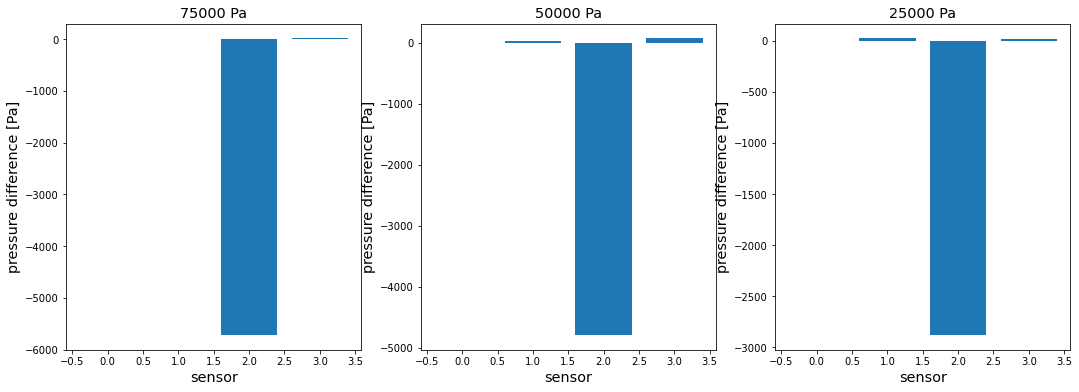

In [13]:
#
# create barplot for all the differences on different levels
#
np.arange(len(pres_delta))
#
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.bar(np.arange(len(pres_delta[0])),(pres_delta[0]))
ax1.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='75000 Pa')
ax2.bar(np.arange(len(pres_delta[1])),(pres_delta[1]))
ax2.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='50000 Pa')
ax3.bar(np.arange(len(pres_delta[2])),(pres_delta[2]))
ax3.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='25000 Pa')
